In [27]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.6 MB/s eta 0:00:00


In [29]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import optuna


In [41]:
df=pd.read_csv('sales.csv')
df['radio tv']   = df['radio'] * df['TV']
df['radio news'] = df['radio'] * df['newspaper']
df['tv news']    = df['TV']    * df['newspaper']
X = df.drop('sales', axis=1)
y = df['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=50)

In [42]:
df

,Unnamed: 0,TV,radio,newspaper,sales,radio tv,radio news,tv news
0,1,230.1,37.8,69.2,22.1,8697.78,2615.76,15922.92
1,2,44.5,39.3,45.1,10.4,1748.85,1772.43,2006.95
2,3,17.2,45.9,69.3,9.3,789.48,3180.87,1191.96
3,4,151.5,41.3,58.5,18.5,6256.95,2416.05,8862.75
4,5,180.8,10.8,58.4,12.9,1952.64,630.72,10558.72
...,...,...,...,...,...,...,...,...
195,196,38.2,3.7,13.8,7.6,141.34,51.06,527.16
196,197,94.2,4.9,8.1,9.7,461.58,39.69,763.02
197,198,177.0,9.3,6.4,12.8,1646.10,59.52,1132.80
198,199,283.6,42.0,66.2,25.5,11911.20,2780.40,18774.32


In [43]:
model =XGBRegressor(
    n_estimators=100,
    max_depth=1000,
    max_leaves=1000
)

model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

r2_test = r2_score(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)

In [ ]:
#https://optuna.org/#code_examples ahi viene un ejemplo
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'max_leaves': trial.suggest_int('max_leaves', 0, 1000),


    }

    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

best_params = study.best_params
best_model = XGBRegressor(**best_params)
best_model.fit(X_train, y_train)
y_pred_test = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

r2_test = r2_score(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
print("r2 test",r2_test)
print("r2 train", r2_train)


In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

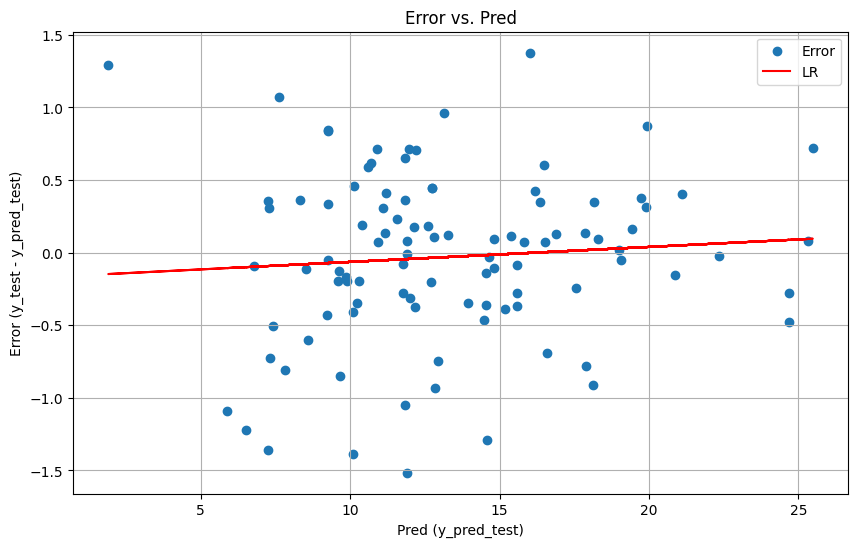

In [52]:
import numpy as np
from sklearn.linear_model import LinearRegression
error = y_test - y_pred_test
model_lr = LinearRegression()
X_lr = y_pred_test.reshape(-1, 1)
model_lr.fit(X_lr, error)
y_pred_lr = model_lr.predict(X_lr)
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, error, label='Error')
plt.plot(y_pred_test, y_pred_lr, color='red', label='LR')
plt.xlabel('Pred (y_pred_test)')
plt.ylabel('Error (y_test - y_pred_test)')
plt.title('Error vs. Pred')
plt.legend()
plt.grid(True)
plt.show()


In [54]:
import statsmodels.api as sm
X_lr = sm.add_constant(y_pred_test)
model_lr = sm.OLS(error, X_lr)
results = model_lr.fit()

print(results.summary())

p_value = results.pvalues[1]

print("coef:", p_value)

alpha = 0.05
if p_value < alpha:
    print("diferente de 0")
else:
    print("pendiente 0")


                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.6526
Date:                Thu, 24 Apr 2025   Prob (F-statistic):              0.421
Time:                        23:42:44   Log-Likelihood:                -86.901
No. Observations:                 100   AIC:                             177.8
Df Residuals:                      98   BIC:                             183.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1680      0.179     -0.937      0.3

<ipython-input-54-397bea6ef889>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = results.pvalues[1]
